# Hyperparameter Inference with `GammaBayes`

Before we get into analysis we will load in the data

In [1]:
from gammabayes import EventData

measured_event_data = EventData.load("tutorial_data/measured_data.h5")

## Setup (as done previously)

I will skip explaining this setup as most of it is done within the `Probability Class` and `Simulations` tutorials.

In [2]:
import numpy as np, time, random
from matplotlib import pyplot as plt

print(time.strftime("%H:%M:%S"))
random.seed(24)


11:28:37


In [3]:
from gammabayes.likelihoods.irfs import IRF_LogLikelihood
from gammabayes.utils.config_utils import (
    read_config_file, 
    create_true_axes_from_config, 
    create_recon_axes_from_config, 
)
from gammabayes.utils import (
    dynamic_import
)

config_file_path = 'ConfigFiles/HyperParameterInference_config.yaml'
config_dict = read_config_file(config_file_path)

source_hyperparameter_input = config_dict['parameter_specifications']
mixture_bounds               = [config_dict['mixture_fraction_specifications'][mixture]['bounds'] for mixture in config_dict['mixture_fraction_specifications']]

NumEvents                   = config_dict['Nevents']
truemass                    = config_dict['dark_matter_mass']
signal_fraction             = config_dict['signal_fraction']
ccr_of_bkg_fraction         = config_dict['ccr_of_bkg_fraction']
diffuse_of_astro_fraction   = config_dict['diffuse_of_astro_fraction']

nsig = int(round(signal_fraction*NumEvents))
nccr = int(round((1-signal_fraction)*ccr_of_bkg_fraction*NumEvents))
ndiffuse = int(round((1-signal_fraction)*(1-ccr_of_bkg_fraction)*diffuse_of_astro_fraction*NumEvents))
nlocal = int(round((1-signal_fraction)*(1-ccr_of_bkg_fraction)*(1-diffuse_of_astro_fraction)*NumEvents))


if nsig+nccr+ndiffuse+nlocal!=NumEvents:
    print(nsig, nccr, ndiffuse, nlocal)

assert nsig+nccr+ndiffuse+nlocal==NumEvents

file path: ConfigFiles/HyperParameterInference_config.yaml


/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
energy_true_axis,  longitudeaxistrue, latitudeaxistrue       = create_true_axes_from_config(config_dict)
energy_recon_axis, longitudeaxis,     latitudeaxis           = create_recon_axes_from_config(config_dict)


irf_loglike = IRF_LogLikelihood(axes   =   [energy_recon_axis,    longitudeaxis,     latitudeaxis], 
                                dependent_axes =   [energy_true_axis,     longitudeaxistrue, latitudeaxistrue],
                                prod_vers='5') # or '3b'/3/'3'

# log_psf_normalisations, log_edisp_normalisations = irf_loglike.create_log_norm_matrices()
# irf_norm_matrix = log_psf_normalisations + log_edisp_normalisations


0.2 90.0 100 0.1 -3.05 3.05 -3.0 3.0
0.2 90.0 50 0.2 -3.05 3.05 -3.0 3.0

Path to irf fits file: /Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/utils/../package_data/irf_fits_files/prod5/CTA-Performance-prod5-v0.1-South-20deg.FITS/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz

Number of input dimensions 3


In [5]:
# np.save('irf_norm_matrix.npy', irf_norm_matrix)
irf_norm_matrix = np.load('irf_norm_matrix.npy')
irf_norm_matrix.shape

(266, 62, 61)

In [6]:
from gammabayes.likelihoods import DiscreteLogLikelihood
from gammabayes.dark_matter import CombineDMComps, DM_ContinuousEmission_Spectrum
from gammabayes.dark_matter.density_profiles import Einasto_Profile, GNFW_Profile
from gammabayes.dark_matter.channel_spectra import (
    PPPCReader, 
)
from gammabayes.priors import DiscreteLogPrior, log_bkg_CCR_dist, TwoCompPrior
dark_matter_spectral_class = dynamic_import('gammabayes.dark_matter.spectral_models', config_dict['dark_matter_spectral_model'])

In [7]:
from gammabayes.dark_matter.spectral_models import Z2_ScalarSinglet


DM_prior = CombineDMComps(name='Z2 Scalar Singlet dark matter',
                        spectral_class = Z2_ScalarSinglet, 
                        spectral_class_kwds={'ratios':True,},
                        spatial_class = Einasto_Profile,
                        irf_loglike=irf_loglike, 
                        axes=(energy_true_axis, 
                              longitudeaxistrue, 
                              latitudeaxistrue,), 
                        axes_names=['energy', 'lon', 'lat'],
                        default_spectral_parameters={
                            'mass':config_dict['dark_matter_mass'],}, )

In [8]:
ccr_bkg_prior = DiscreteLogPrior(logfunction=log_bkg_CCR_dist, name='CCR Mis-identification Background',
                               axes=(   energy_true_axis, 
                                        longitudeaxistrue, 
                                        latitudeaxistrue,), 
                                    axes_names=['energy', 'lon', 'lat'], )


from gammabayes.priors.astro_sources import FermiGaggeroDiffusePrior, HESSCatalogueSources_Prior
diffuse_astro_bkg_prior = FermiGaggeroDiffusePrior(energy_axis=energy_true_axis, longitudeaxis=longitudeaxistrue, latitudeaxis=latitudeaxistrue, irf=irf_loglike)
point_astro_bkg_prior = HESSCatalogueSources_Prior(energy_axis=energy_true_axis, longitudeaxis=longitudeaxistrue, latitudeaxis=latitudeaxistrue, irf=irf_loglike)


/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/priors/core/discrete_logprior.py:64: UserWarning: No function to calculate on mesh efficiently given
  warnings.warn('No function to calculate on mesh efficiently given')
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/priors/core/discrete_logprior.py:64: UserWarning: No function to calculate on mesh efficiently given
  warnings.warn('No function to calculate on mesh efficiently given')
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammapy/modeling/models/spatial.py:583: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/priors/core/discrete_logprior.py:64: UserWarning: No function to calculate on mesh efficiently given
  warnings.warn('No function to calculate on mesh efficiently given')


## Nuisance Parameter Marg

The main computational cost of `GammaBayes` is also the process that allows us to use some interesting statistical tools, being the marginalisation of the nuisance parameters/true event values. `DiscreteAdaptiveScan` is a class that does this calculation by adaptively restricting the range of parameter space one has to integrate over rather than the whole space and directly integrating the likelihoods and priors via effectively matrix addition. 

This is done because the likelihoods are so localised you don't have to go very far away from the measured event values to look at 99.99998% of the non-zero probability values. This both reduces computation time and the amount of memory required to do the analysis.

We will first load it in along with the `ParameterSet` class that is a nice wrapper for storing multiple parameters within a single object.

In [9]:
from gammabayes.hyper_inference import DiscreteAdaptiveScan as discrete_scan_hyperparameter_likelihood
from gammabayes import ParameterSet

The basic inputs for the class are given below, you must specify 
- the possible true and measured event axes (accessed here through `DM_prior.axes` and `irf_loglike.axes` respectively), 
- the log-priors to be used for marginalisation (i.e. the `log_priors` argument), 
- the log-likelihood (i.e. the `log_likelihood` argument), 
- the given parameters and how you wish to explore their given values for the given priors (i.e. a list of `ParameterSet` objects, nested dictionary or list of dictionaries `prior_parameter_specifications`), 
- currenty one also has to specify a matrix of log-normalisation values for the IRF likelihood, as the normalisation can slightly change depending on the axis configuration and the given matrices are too large to store within a standard python package
- One can also specify the radii about the measured values about which you will explore the space of true values. We typically recommend to not specify these and the class will calculate them itself based on the given IRF.
- how you wish to explore their given values (either `sample` or `scan`, for most use cases we recommend `sample` if possible), 

In [10]:
discrete_scan_hyperparameter_likelihood_instance = discrete_scan_hyperparameter_likelihood(
    log_priors=(DM_prior, ccr_bkg_prior, diffuse_astro_bkg_prior, point_astro_bkg_prior),
    log_likelihood=irf_loglike, 
    nuisance_axes = DM_prior.axes, 
    axes=irf_loglike.axes,
    prior_parameter_specifications=config_dict['parameter_specifications'], 
    log_likelihoodnormalisation=irf_norm_matrix,
    bounds=[['log10', 0.36], ['linear', 0.44], ['linear', 0.44]],
    mixture_fraction_exploration_type='sample')


/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/hyper_inference/utils.py:54: UserWarning: 
You have specifed 3 less hyperparameter axes than priors. 
Assigning empty hyperparameter axes for remaining priors.
  warnings.warn(f"""


The method `nuisance_log_marginalisation` then performs the calculations that include the various parameter values for the priors.

In [11]:
reshaped_log_marg_results = discrete_scan_hyperparameter_likelihood_instance.nuisance_log_marginalisation(
    measured_event_data=measured_event_data)

Setting up prior matrices:   0%|          | 0/4 [00:00<?, ?it/s]

Setting up prior matrices: 100%|██████████| 4/4 [00:55<00:00, 13.81s/it]


From here, we want to combine these results for the priors into a mixture model using a stick-breaking Dirichlet process. For that we need to specify how we wish to explore the mixture fractions/parameters. To decrease the complications due to multiprocessing we extract the log of the results of the nuisance parameter marginalisations (i.e `reshaped_log_marg_results`) and do the setup for the chosen mixture parameter exploration ('scan' or 'sample') with the `select_scan_output_exploration_class` method. 

Giving it the ways we wish to explore the mixture parameters.

In [12]:
mixture_parameter_set = ParameterSet(config_dict['mixture_fraction_specifications'])
prior_parameters = ParameterSet(config_dict['parameter_specifications'])

discrete_scan_hyperparameter_likelihood_instance.log_nuisance_marg_results = reshaped_log_marg_results

discrete_scan_hyperparameter_likelihood_instance.select_scan_output_exploration_class(
    log_nuisance_marg_results=reshaped_log_marg_results,
    mixture_parameter_specifications=mixture_parameter_set,
    prior_parameter_specifications = [ParameterSet(config_dict['parameter_specifications']),],
)

The API for whatever method you choose should be the same from the methods used. However, because we chose the 'sample' method what we are doing is using a nested sampler, spefically `dynesty`, to explore the hyperparameters space (mixture parameters and the pretty much already computed prior parameter values). So we can specify the number of live points we wish to use among other parameters that are used when initialising such a sampler.

In [21]:
discrete_scan_hyperparameter_likelihood_instance.init_posterior_exploration(nlive=500) # Higher than needed, but makes posteriors smoother

Then mimicing the `run_nested` method for the `dynesty` samplers we have the `run_posterior_exploration` method, for which any keyword argument simply gets passed into the `dynesty` sampler `run_nested` method. i.e. We can specify the stopping conditions for finishing the sampling such as `dlogz`.

In [23]:
discrete_scan_hyperparameter_likelihood_instance.run_posterior_exploration(dlogz=0.01) # dlogz lower than required, but again makes the results prettier

6775it [00:00, 120982.16it/s, +500 | bound: 22 | nc: 1 | ncall: 34901 | eff(%): 21.148 | loglstar:   -inf < -6464.234 <    inf | logz: -6473.160 +/-  0.117 | dlogz:  0.000 >  0.010]


We can get the results of either method ('sample' or 'scan') via the `posterior_exploration_results` attribute which other outputs the log of the generated hyperparameter posterior matrix (for the 'scan' method) or the `results` attribute of the nested sampler.

Plotting this using corner, keeping in mind that the mass parameter has been taken to be discrete, hence the evident binning for the parameter.

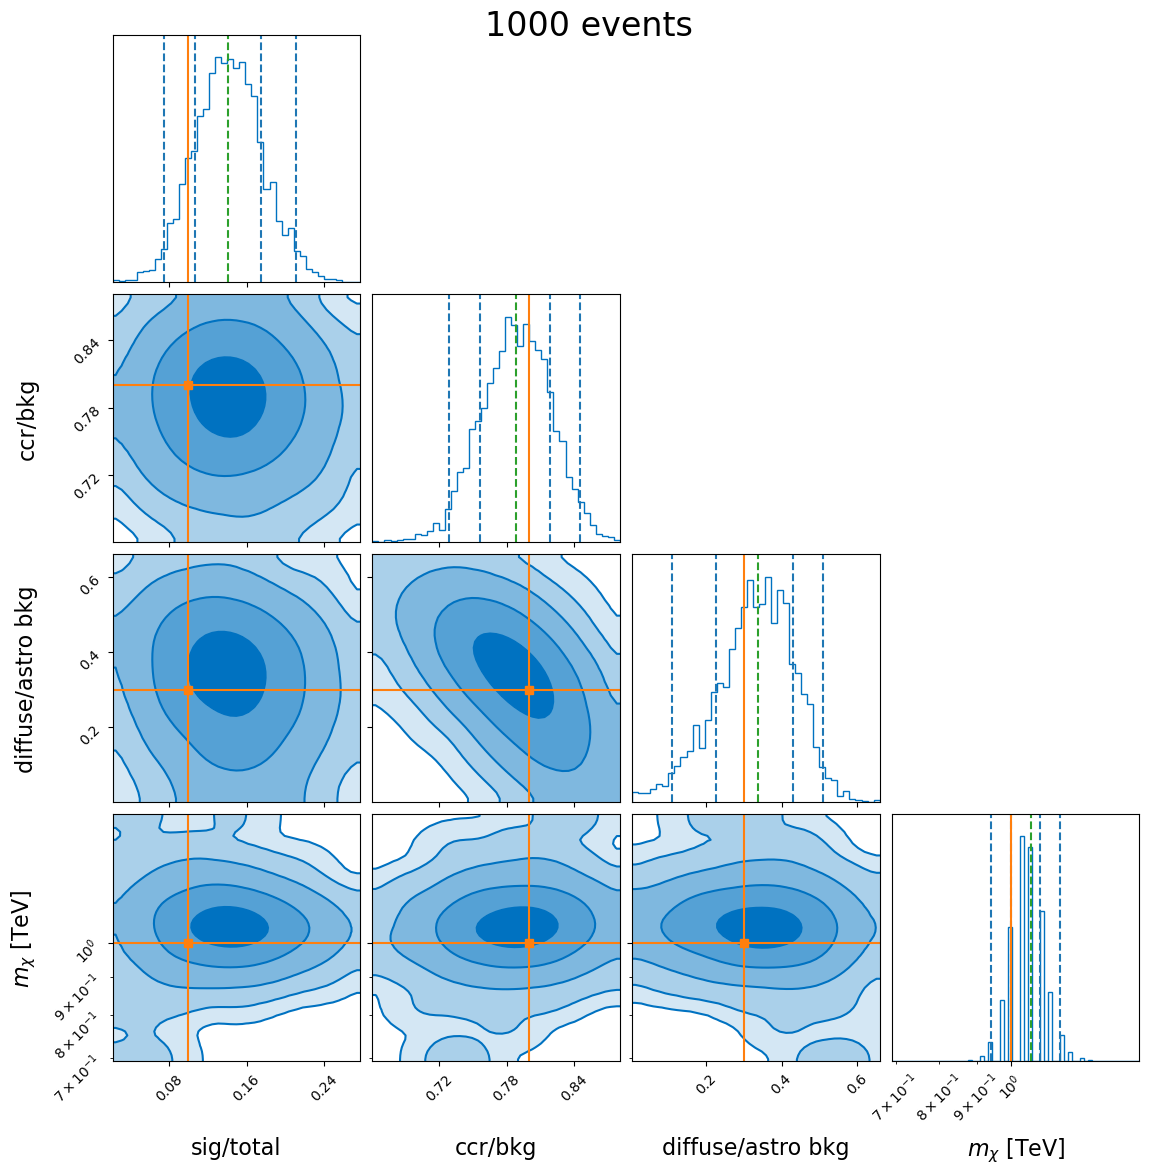

In [29]:
from corner import corner
from gammabayes.utils.plotting import defaults_kwargs
from scipy.special import logsumexp
# defaults_kwargs['smooth'] = 3



num_params = 4
sampling_results = discrete_scan_hyperparameter_likelihood_instance.posterior_exploration_results
weights = np.exp(sampling_results.logwt - logsumexp(sampling_results.logwt))  # Calculate normalized weights

fig = plt.figure(figsize=(12,12))
figure=corner(sampling_results.samples_equal(), fig=fig,
       labels=['sig/total', 'ccr/bkg', 'diffuse/astro bkg', r'$m_{\chi}$ [TeV]'],
       truths=[0.1,0.8, 0.3, 1.0],
       quantiles=[0.025, .16, 0.5, .84, 0.975],
       bins=[41, 41, 41,*[axis.size*2 for axis in prior_parameters.axes]],
       axes_scale=['linear', 'linear', 'linear', 'log',],
    
       **defaults_kwargs)

for ax_idx, ax in enumerate(figure.get_axes()):
    # Find lines representing the quantiles (the 3rd line for each histogram is the median, based on the ordering in `quantiles`)
    lines = ax.get_lines()
    if (len(lines) > 2):
        if (ax_idx%(num_params+1)==0): 
            for line_idx, line in enumerate(lines): # Check if there are enough lines (for histograms)
                if line_idx==2:
                    line.set_color('tab:green')  # Change the color of the median lines
                elif line_idx<len(lines)-1:
                    line.set_color('tab:blue')
plt.suptitle(str(measured_event_data.Nevents) + " events", size=24)


plt.show()


### Saving Results

There are a couple of different ways to save your results from the `DiscreteAdaptiveScan` inference class. For storing all possible values we recommend the `save_to_pickle` method, but know that for a large number of events (e.g. 10^8 the size can be in the GB range).

In [30]:
discrete_scan_hyperparameter_likelihood_instance.save_to_pickle('tutorial_data/test_results.pkl')

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/hyper_inference/discrete_brute_scan_hyperparameter_likelihood.py:1045: UserWarning: Reduce memory consumption enabled. Not saving log_nuisance_marg_results.
  warnings.warn("Reduce memory consumption enabled. Not saving log_nuisance_marg_results.")


In [31]:
discrete_scan_hyperparameter_likelihood_instance.hyper_analysis_instance


This can then be loaded via the method below.

In [32]:
loaded_discrete_scan_hyperparameter_likelihood = discrete_scan_hyperparameter_likelihood.load_from_pickle(
    file_name='tutorial_data/test_results.pkl')

For the sampling method we generally recommend if you have also saved the given configuration of the analysis in a separate yaml file already, to simply save the `results` attribute of the sampler. This way you save the posterior samples, and log evidence values. By default the save method uses the write method 'w-' so that files are not overwritten, but that isn't a concern here.

In [35]:
from gammabayes.samplers.sampler_utils import ResultsWrapper
ResultsWrapper.save('tutorial_data/posterior_samples.h5', 
                    discrete_scan_hyperparameter_likelihood_instance.hyper_analysis_instance.results,
                    write_mode='w')
